Tournament Format:

4 pools of 5 countries. These countries play in their own round robin in their pools. Then the top team from each of these pools advance to knockouts, and the 2nd and 3rd from each pool (8 teams total) play a qualifer round robin and the top 4 in that qualifies to the knockouts. 

The rankings of 9th to 12th is finalised here. 

the 13 to 20 is determined by another round robin.

DOUBLE ROUND ROBIN

In [63]:
import random
import pandas as pd
from itertools import combinations, chain

import matplotlib.pyplot as plt
import numpy as np


numtrials = 1000
totaltime = 0
total_games_played = 0

In [64]:
countries = [
    "Brazil",
    "Spain",
    "France",
    "Argentina",
    "Uruguay",
    "Colombia",
    "United Kingdom",
    "Paraguay",
    "Germany",
    "Ecuador",
    "Portugal",
    "Italy",
    "Morocco",
    "Egypt",
    "South Korea",
    "Japan",
    "Mexico",
    "Costa Rica",
    "New Zealand",
    "Australia",
]

pools = {
    1: ['Mexico', 'Costa Rica', 'Ecuador', 'Colombia'],
    2: ['Brazil', 'Paraguay', 'Uruguay', "Argentina"],
    3: ['South Korea', 'Japan', 'New Zealand', 'Australia'],
    4: ['United Kingdom', 'Germany', 'France', 'Italy', 'Spain', 'Portugal', 'Morocco', 'Egypt']
}

# 1: mexico, costarica, ecuador, colombia
# 2: brazil, paraguay, uruguay, argentina
# 3 SK, japan, NZ, aus
# 4 UK, Germany, France, Italy, Spain, , Portugal, Morocco, Egypt



elo_ratings = [
    1994,
    2150,
    2031,
    2140,
    1922,
    1953,
    2012,
    1799,
    1988,
    1911,
    1988,
    1914,
    1807,
    1668,
    1745,
    1875,
    1817,
    1653,
    1596,
    1736,
]

countriesratings = {country: elo_ratings[countries.index(country)] for country in countries}


In [65]:
import folium
from IPython.display import display

locations = [
    (-14.2350, -51.9253),  # Brazil
    (40.4637, -3.7492),    # Spain
    (46.6034, 1.8883),     # France
    (-38.4161, -63.6167),  # Argentina
    (-32.5228, -55.7659),  # Uruguay
    (4.5709, -74.2973),    # Colombia
    (55.3781, -3.4360),    # United Kingdom
    (-23.4420, -58.4438),  # Paraguay
    (51.1657, 10.4515),    # Germany
    (-1.8312, -78.1834),   # Ecuador
    (39.3999, -8.2245),    # Portugal
    (41.8719, 12.5674),    # Italy
    (31.7915, -7.0926),    # Morocco
    (26.8206, 30.8025),    # Egypt
    (35.9078, 127.7669),   # South Korea
    (36.2048, 138.2529),   # Japan
    (23.6345, -102.5528),  # Mexico
    (9.7489, -83.7534),    # Costa Rica
    (-40.9006, 174.8860),  # New Zealand
    (-25.2744, 133.7751),   # Australia
]

locationdict = {country: locations[countries.index(country)] for country in countries}
print(locationdict)

games_played_country = {country: 0 for country in countries}

# plot all countries on a map
m = folium.Map(location=[20, 20], zoom_start=2)
for name, rating, location in zip(countries, countriesratings.values(), locations):
    folium.Marker(
        location=location,
        icon=folium.Icon(color="red"),
        tooltip=f"{name} [{rating}]",
    ).add_to(m)
display(m)

{'Brazil': (-14.235, -51.9253), 'Spain': (40.4637, -3.7492), 'France': (46.6034, 1.8883), 'Argentina': (-38.4161, -63.6167), 'Uruguay': (-32.5228, -55.7659), 'Colombia': (4.5709, -74.2973), 'United Kingdom': (55.3781, -3.436), 'Paraguay': (-23.442, -58.4438), 'Germany': (51.1657, 10.4515), 'Ecuador': (-1.8312, -78.1834), 'Portugal': (39.3999, -8.2245), 'Italy': (41.8719, 12.5674), 'Morocco': (31.7915, -7.0926), 'Egypt': (26.8206, 30.8025), 'South Korea': (35.9078, 127.7669), 'Japan': (36.2048, 138.2529), 'Mexico': (23.6345, -102.5528), 'Costa Rica': (9.7489, -83.7534), 'New Zealand': (-40.9006, 174.886), 'Australia': (-25.2744, 133.7751)}


In [66]:
from math import radians, sin, cos, sqrt, atan2


# DISTANCE CALCULATIONS
def haversine(pos1, pos2):
    lat1, lon1 = pos1
    lat2, lon2 = pos2
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    # Haversine formula
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    R = 6371.0 # Radius of Earth in kilometers
    return R * c # Distance in kilometers


def estimate_flight_time(pos1, pos2, speed_kmh=900):
    distance = haversine(pos1, pos2)
    time_hours = distance / speed_kmh
    return time_hours

estimate_flight_time(locations[0], locations[1])  # Example flight time between Argentina and Brazil

8.722425730750562

In [67]:
# Elo system
def winrate(country1, country2):
    return (1/(1 + 10**((countriesratings[country2]-countriesratings[country1])/400)))

In [ ]:
def evaluate_ranking(ranking, true_ranking):
    """Determines how good a ranking is."""

    loss = 0

    # For each pair of countries in the ranking
    for i, A in enumerate(countries):
        for j, B in enumerate(countries):
            if i >= j:
                continue
            rank_A = ranking.index(A) + 1
            rank_B = ranking.index(B) + 1
            true_A = true_ranking.index(A) + 1
            true_B = true_ranking.index(B) + 1
            if (rank_A < rank_B) == (true_A < true_B):
                continue

            W = (
                1 / true_A
                + 1 / true_B
                + 1 / rank_A
                + 1 / rank_B
            )
            loss += W * (1 - abs(0.5 - winrate(A, B)))
    return loss

In [69]:

def simulate_match(country1, country2):
    
    global totaltime
    totaltime += estimate_flight_time(locationdict[country1], locationdict[country2])
    
    global total_games_played
    total_games_played += 1
    
    games_played_country[country1] += 1
    games_played_country[country2] += 1
    
    percent1 = winrate(country1, country2)
    
    if random.random() < percent1:
        result = 'win'
    else:
        result = 'loss'
    
    if result == 'win':
        return country1, 3, country2, 0  # country1 wins, gets 3 points, country2 gets 0
    elif result == 'loss':
        return country1, 0, country2, 3  # country2 wins, gets 3 points, country1 gets 0
    else:
        return country1, 1, country2, 1  # Draw, both get 1 point each
    


In [70]:
def init_standings(teams):
    return {team: {'wins': 0, 'losses': 0, 'draws': 0, 'points': 0} for team in teams}

In [71]:
def round_robin(teams):
    standings = init_standings(teams)
    for team1, team2 in combinations(teams, 2):
        t1, p1, t2, p2 = simulate_match(team1, team2)
        standings[t1]['points'] += p1
        standings[t2]['points'] += p2
        if p1 == 3:
            standings[t1]['wins'] += 1
            standings[t2]['losses'] += 1
        elif p2 == 3:
            standings[t2]['wins'] += 1
            standings[t1]['losses'] += 1
        else:
            standings[t1]['draws'] += 1
            standings[t2]['draws'] += 1
    return standings

In [72]:
def sort_standings(standings):
    df = pd.DataFrame(standings).T
    df = df.sort_values(by=['points', 'wins'], ascending=False)
    return df

In [73]:
def simulate_knockout(teams):
    seeded = []
    
    for country in teams:
        seeded.append((country, countriesratings[country]))
    
    seeded.sort(key=lambda x: x[1], reverse=True)
    quarter_finalists = [seeded[0][0], seeded[7][0], seeded[3][0], seeded[4][0], seeded[1][0], seeded[6][0], seeded[2][0], seeded[5][0]]
    semi_finalists = []
    bottom4 = []
    thirdfourth = []
    

    # Quarterfinals
    for i in range(0, 8, 2):
        team1, team2 = quarter_finalists[i], quarter_finalists[i+1]
        winner = simulate_match(team1, team2)[0 if random.random() < winrate(team1, team2) else 2]
        semi_finalists.append(winner)
        if winner != team1:
            bottom4.append(team1)
        else:
            bottom4.append(team2)
    
    # Sort bottom4 based on the order they appear in the list seeded
    bottom4.sort(key=lambda x: next(i for i, v in enumerate(seeded) if v[0] == x))

    # Semifinals
    finalists = []
    for i in range(0, 4, 2):
        team1, team2 = semi_finalists[i], semi_finalists[i+1]
        winner = simulate_match(team1, team2)[0 if random.random() < winrate(team1, team2) else 2]
        finalists.append(winner)
        if winner != team1:
            thirdfourth.append(team1)
        else:
            thirdfourth.append(team2)
    thirdfourth.sort(key=lambda x: next(i for i, v in enumerate(seeded) if v[0] == x))
    

    # Final
    final_winner = simulate_match(finalists[0], finalists[1])[0 if random.random() < winrate(team1, team2) else 2]
    if final_winner != finalists[0]:
        second = finalists[0]
    else:
        second = finalists[1]
    
    return {
        bottom4[0]: 5,
        bottom4[1]: 6,
        bottom4[2]: 7,
        bottom4[3]: 8,
        thirdfourth[0]: 3,
        thirdfourth[1]: 4,
        second: 2,
        final_winner: 1
    }

In [74]:
avgstandings = {country: 0 for country in countries}

def get_elo(name):
    return countriesratings[name]

countries_ranked = sorted(countries, key=get_elo, reverse=True)
loss_total = 0

for _ in range(numtrials):
    pool_results = {}
    direct_to_quarters = []
    qualifier_candidates = []
    bottom8 = []
    ninthtwelve = []

    # ---------- Phase 1: Group Roundrobin ----------
    for pool_name, teams in pools.items():
            
        standings = round_robin(teams)
        standings2 = round_robin(teams)
        
        for country in standings:
            standings[country]['points'] += standings2[country]['points']
            standings[country]['wins'] += standings2[country]['wins']
            standings[country]['losses'] += standings2[country]['losses']
            standings[country]['draws'] += standings2[country]['draws']
        
        df = sort_standings(standings)
        pool_results[pool_name] = df
        direct_to_quarters.append(df.index[0])      # Top 1 to quarters
        qualifier_candidates.extend(df.index[1:3]) 
        
        if len(teams) == 4:
            bottom8.append(df.index[3])
        else:
            bottom8.extend(df.index[3:8])
            

    # ---------- Phase 2: Qualifiers: Next 8 teams run in qualifiers ----------
    qualifier_results = round_robin(qualifier_candidates)
    qualifer2 = round_robin(qualifier_candidates)
    for country in qualifier_results:
        qualifier_results[country]['points'] += qualifer2[country]['points']
        qualifier_results[country]['wins'] += qualifer2[country]['wins']
        qualifier_results[country]['losses'] += qualifer2[country]['losses']
        qualifier_results[country]['draws'] += qualifer2[country]['draws']
    qualifier_df = sort_standings(qualifier_results)
    qualifier_top4 = list(qualifier_df.index[:4])
    ninthtwelve.extend(qualifier_df.index[4:])

    # ---------- Phase 3: Knockout ----------
    knockout_teams = direct_to_quarters + qualifier_top4
    knockout_results = simulate_knockout(knockout_teams)
    
    # ---------- Phase 4: Placement Round ----------
    placement_results = round_robin(bottom8)
    placement2 = round_robin(bottom8)
    for country in placement_results:
        placement_results[country]['points'] += placement2[country]['points']
        placement_results[country]['wins'] += placement2[country]['wins']
        placement_results[country]['losses'] += placement2[country]['losses']
        placement_results[country]['draws'] += placement2[country]['draws']
    placement_df = sort_standings(placement_results)
    
    
    sorted_placement = sorted(placement_results.keys(), key=lambda x: placement_results[x]['points'], reverse=True)
    standings = init_standings(countries)

    rank = 13
    for country in sorted_placement:
        standings[country] = rank
        rank += 1

    sorted_knockout = sorted(knockout_results.items(), key=lambda x: x[1])
    for country, position in sorted_knockout:
        standings[country] = position
        
    rank = 9
    for country in ninthtwelve:
        standings[country] = rank
        rank += 1
        
    sorted_countries = sorted(standings.keys(), key=lambda x: standings[x])
    
    loss_total += evaluate_ranking(sorted_countries, countries_ranked)
        
    for country, position in standings.items():
        avgstandings[country] += position
        
for country, position in avgstandings.items():
    avgstandings[country] = position/numtrials
print(avgstandings)



{'Brazil': 5.153, 'Spain': 3.206, 'France': 8.111, 'Argentina': 2.958, 'Uruguay': 9.525, 'Colombia': 5.859, 'United Kingdom': 8.377, 'Paraguay': 13.927, 'Germany': 10.33, 'Ecuador': 7.441, 'Portugal': 11.118, 'Italy': 14.402, 'Morocco': 17.011, 'Egypt': 18.911, 'South Korea': 10.819, 'Japan': 7.641, 'Mexico': 9.709, 'Costa Rica': 16.718, 'New Zealand': 16.481, 'Australia': 12.303}


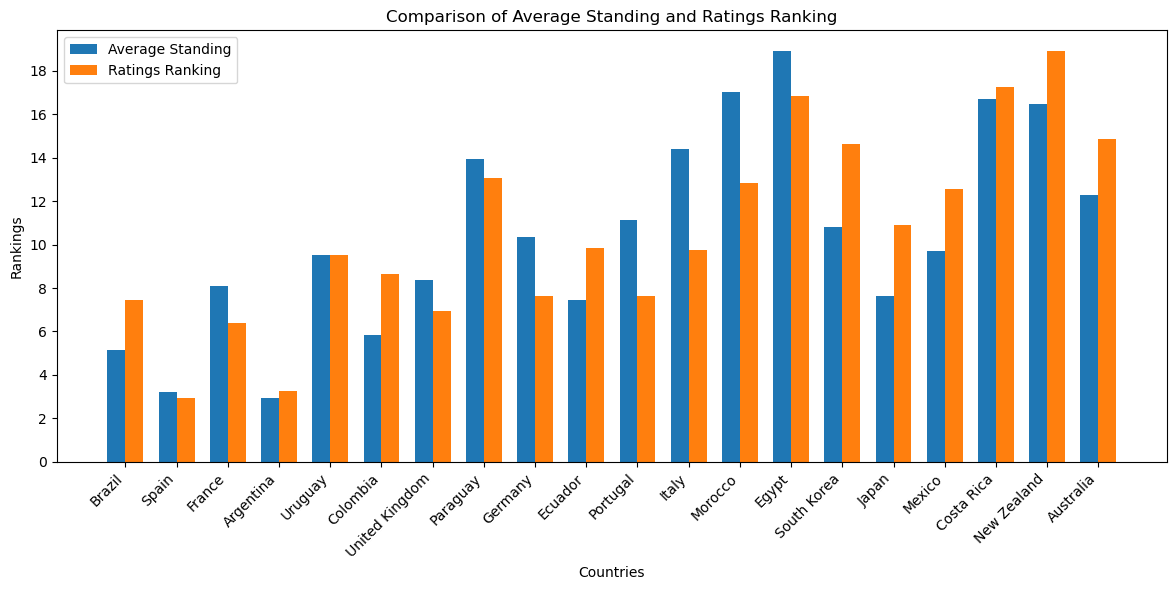

Total games played: 211.0
Total time: 2919.5591779365795 hours
{'Brazil': 17.668, 'Spain': 22.169, 'France': 26.953, 'Argentina': 13.652, 'Uruguay': 19.338, 'Colombia': 15.616, 'United Kingdom': 27.05, 'Paraguay': 19.861, 'Germany': 27.516, 'Ecuador': 15.41, 'Portugal': 27.73, 'Italy': 28.001, 'Morocco': 28.0, 'Egypt': 28.0, 'South Korea': 16.688, 'Japan': 12.449, 'Mexico': 17.833, 'Costa Rica': 19.798, 'New Zealand': 19.781, 'Australia': 18.487}
Average Loss: 23.71230593459172


In [75]:
# ---------------------------- PLOTTING ---------------------------------
# Calculate rankings based on countriesratings
ratings_ranking = {country: rank for rank, country in enumerate(sorted(countriesratings, key=countriesratings.get, reverse=True), start=1)}

# Prepare data for the bar graph
avg_standings_values = [avgstandings[country] for country in countries]

# Perform max-min normalization for ratings
min_avg_standing = min(avg_standings_values)
max_avg_standing = max(avg_standings_values)

normalized_ratings = {
    country: max_avg_standing - ((max_avg_standing - min_avg_standing) * (countriesratings[country] - min(countriesratings.values())) / 
                                 (max(countriesratings.values()) - min(countriesratings.values())))
    for country in countries
}

ratings_ranking_values = [normalized_ratings[country] for country in countries]

x = np.arange(len(countries))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, avg_standings_values, width, label='Average Standing')
rects2 = ax.bar(x + width/2, ratings_ranking_values, width, label='Ratings Ranking')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Countries')
ax.set_ylabel('Rankings')
ax.set_title('Comparison of Average Standing and Ratings Ranking')
ax.set_xticks(x)
ax.set_xticklabels(countries, rotation=45, ha='right')
ax.legend()
fig.tight_layout()

ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.show()
print(f"Total games played: {total_games_played/numtrials}")
print(f"Total time: {2 * (totaltime/numtrials)} hours")

for country, num in games_played_country.items():
    games_played_country[country] = num/numtrials
print(games_played_country)
print(f"Average Loss: {loss_total/numtrials}")